<a href="https://colab.research.google.com/github/vchandraiitk/datascience/blob/main/M7_NB_MiniProject_2_Simple_Analytics_Pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science
## A program by IISc and TalentSprint
### Mini-Project: Simple Analytics using Pyspark

## Problem Statement

Perform simple analytics with Pyspark on the real estate valuation dataset and predict the house price per unit area

## Learning Objectives

At the end of the mini-project, you will be able to :

* analyze the data using pyspark
* derive the insights and visualize the data
* implement linear regression and evaluate using pyspark

### Dataset

The dataset chosen for this mini-project is **Real Estate Valuation dataset**. The data was collected from the historical market of real estate within Sindian District of New Taipei City, the timespan across 2012 August to 2013 July. In the dataset, the response variable (house price per unit area) is calculated in a local unit which is approximately $10000 New Taipei Dollar per 3.3 squared meters. For the collection of regressor data, the transaction dates are transformed into a format such that 2013.250 = 2013 March, 2013.500 = 2013 June etc. The house age was collected in years and the distance to MRT stations is measured in meters.

**Reference:**
The original owner of this Real Estate Valuation dataset is professor I-Cheng Yeh from TamKang University (Department of Civil Engineering). Prof. Yeh donated this dataset to UCI machine learning repository on 18th August 2018. The dataset can be accessed at https://archive.ics.uci.edu/ml/datasets/Real+estate+valuation+data+set#[1].

## Grading = 10 Points

#### Install Pyspark

In [1]:
#@title Install pyspark and Download the data
!pip -qq install pyspark
!pip -qq install handyspark
!pip install numpy==1.23.0
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/RealEstate.csv
print("Packages installed and dataset downloaded successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 71.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.19 requires numpy>=1.24.4, but you have numpy 1.23.0 which is incompatible.
albumentations 1.4.20 requires numpy>=1.24.4, but you have numpy 1.23.0 which is incompatible.
bigframes 1.30.0 requires numpy>=1.24.0, but you have numpy 1.23.0 which is incompatible.
chex 0.1.88 requires numpy>=1.24.1, but you have numpy 1.23.0 which is incompatible.
ibis-framework 9.2.0 requires numpy<3,>=1.23.2, but you have numpy 1.23.0 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.0 which is incompatible.
jax 0.4.33 requires numpy>=1.24, but yo

Packages installed and dataset downloaded successfully!


#### Import required packages

In [31]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import MinMaxScaler
from handyspark import *
import seaborn as sns
from matplotlib import pyplot as plt

### Data Loading (1 point)

#### Start a Spark Session

Spark session is a combined entry point of a Spark application, which came into implementation from Spark 2.0. It provides a way to interact with various spark’s functionality with a lesser number of constructs.

In [32]:
spark = SparkSession.builder.appName('RealEstate').getOrCreate()

#### Load the data and infer the schema

To load the dataset use the `read.csv` with `inferSchema` and `header` as parameters.

In [33]:
csv_path = "/content/RealEstate.csv"
# YOUR CODE HERE
dataset = spark.read.csv(csv_path, inferSchema=True, header=True)

In [34]:
dataset = dataset.select(
    col("X1 transaction date").alias("transaction_date"),
    col("X2 house age").alias("house_age"),
    col("X3 distance to the nearest MRT station").alias("distance"),
    col("X4 number of convenience stores").alias("no_of_stores"),
    col("X5 latitude").alias("latitude"),
    col("X6 longitude").alias("longitude"),
    col("Y house price of unit area").alias("house_price"))

#### Fetch the data using handyspark

* Create a HandyFrame using handyspark `toHandy()` function

* using an instance of `cols` from your HandyFrame, you can retrieve values for given columns in the top N rows

Hint: [toHandy()](https://dvgodoy.github.io/handyspark/includeme.html)

In [35]:
# YOUR CODE HERE
handyFrame = dataset.toHandy()
handyFrame.show(5)

+----------------+---------+--------+------------+--------+---------+-----------+
|transaction_date|house_age|distance|no_of_stores|latitude|longitude|house_price|
+----------------+---------+--------+------------+--------+---------+-----------+
|        2012.917|     32.0|84.87882|          10|24.98298|121.54024|       37.9|
|        2012.917|     19.5|306.5947|           9|24.98034|121.53951|       42.2|
|        2013.583|     13.3|561.9845|           5|24.98746|121.54391|       47.3|
|          2013.5|     13.3|561.9845|           5|24.98746|121.54391|       54.8|
|        2012.833|      5.0|390.5684|           5|24.97937|121.54245|       43.1|
+----------------+---------+--------+------------+--------+---------+-----------+
only showing top 5 rows



### Deriving the insights (2 points)

#### show the no. of records per month

Hint: Apply [groupby](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.GroupedData.agg.html) on transaction date and count the records using aggregation `agg()`

In [36]:
# YOUR CODE HERE
dataset.groupBy("transaction_date").agg(count("transaction_date").alias("count")).show()

+----------------+-----+
|transaction_date|count|
+----------------+-----+
|         2012.75|   27|
|        2013.333|   29|
|        2013.083|   46|
|        2012.833|   31|
|          2013.5|   47|
|        2013.583|   23|
|        2013.417|   58|
|        2013.167|   25|
|         2013.25|   32|
|          2013.0|   28|
|        2012.917|   38|
|        2012.667|   30|
+----------------+-----+



#### how much is the increase in the average house price in 2012 to 2013

Hint: Apply [filter](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.filter.html) on the transaction date and aggregate the house price using mean

In [37]:
dataset.printSchema()

root
 |-- transaction_date: double (nullable = true)
 |-- house_age: double (nullable = true)
 |-- distance: double (nullable = true)
 |-- no_of_stores: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- house_price: double (nullable = true)



In [38]:
# YOUR CODE HERE
from pyspark.sql.types import IntegerType # Import IntegerType
def avgPrice(year):
    return dataset.filter(dataset["transaction_date"].cast(IntegerType()) == year).agg(avg("house_price")).collect()[0][0]
avgPrice(2013) - avgPrice(2012)

2.4084325396825506

#### Find the count of houses with no convenience store and show the top 10 records

In [39]:
# YOUR CODE HERE
filtered_data = dataset.filter(dataset["no_of_stores"] == 0)
print(filtered_data.count())
filtered_data.show(10)

67
+----------------+---------+--------+------------+--------+---------+-----------+
|transaction_date|house_age|distance|no_of_stores|latitude|longitude|house_price|
+----------------+---------+--------+------------+--------+---------+-----------+
|          2013.5|     25.9| 4519.69|           0|24.94826|121.49587|       22.1|
|          2013.5|     13.9|4079.418|           0|25.01459|121.51816|       27.3|
|          2013.0|     13.6|4082.015|           0|24.94155|121.50381|       15.9|
|          2013.5|     16.8|4066.587|           0|24.94297|121.50342|       18.2|
|        2013.417|     24.2|4605.749|           0|24.94684|121.49578|       13.4|
|        2012.833|     31.7|1160.632|           0|24.94968|121.53009|       13.7|
|        2013.333|     17.5|995.7554|           0|24.96305|121.54915|       25.3|
|        2013.167|     13.8|4082.015|           0|24.94155|121.50381|       20.0|
|        2013.583|     16.9|4066.587|           0|24.94297|121.50342|       18.3|
|        2012

#### Compare the maximum price of houses *with convenient store* and *without convenience store*

In [40]:
# YOUR CODE HERE
dataset.groupBy("no_of_stores").agg(max("house_price")).show()
dataset.groupBy("no_of_stores").agg(max("house_price")).show()

+------------+----------------+
|no_of_stores|max(house_price)|
+------------+----------------+
|           1|           117.5|
|           6|            73.6|
|           3|            61.5|
|           5|            60.7|
|           9|            78.3|
|           4|            62.9|
|           8|            67.7|
|           7|            62.1|
|          10|            61.9|
|           2|            50.5|
|           0|            55.3|
+------------+----------------+

+------------+----------------+
|no_of_stores|max(house_price)|
+------------+----------------+
|           1|           117.5|
|           6|            73.6|
|           3|            61.5|
|           5|            60.7|
|           9|            78.3|
|           4|            62.9|
|           8|            67.7|
|           7|            62.1|
|          10|            61.9|
|           2|            50.5|
|           0|            55.3|
+------------+----------------+



In [41]:
from pyspark.sql.functions import col
dataset.filter(col("no_of_stores") > 0).agg(max("house_price").alias("Max with Convenience Stores")).show()
dataset.filter(col("no_of_stores") == 0).agg(max("house_price").alias("Max w/o Convenience Stores")).show()

+---------------------------+
|Max with Convenience Stores|
+---------------------------+
|                      117.5|
+---------------------------+

+--------------------------+
|Max w/o Convenience Stores|
+--------------------------+
|                      55.3|
+--------------------------+



#### Decode the transaction date

* create a year column separately by removing the decimal places from transaction date column

    Hint: `withColumn()`

* create a month column separately based on the decimal places from the transaction date column

 **Hints:** multiply decimal place number with 12 and apply round off, perform below steps
     
     - use `udf()` from pyspark
     - subtracting `transaction date` from `int(transaction date)` will give the decimal place number
     - multiply the result with 12 and roundoff

To know more about udf(), click [here](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.udf.html)

In [42]:
# YOUR CODE HERE
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql.types import StringType
dataset = dataset.withColumn("Year", col("transaction_date").cast(IntegerType()))

In [43]:
dataset.show(5)

+----------------+---------+--------+------------+--------+---------+-----------+----+
|transaction_date|house_age|distance|no_of_stores|latitude|longitude|house_price|Year|
+----------------+---------+--------+------------+--------+---------+-----------+----+
|        2012.917|     32.0|84.87882|          10|24.98298|121.54024|       37.9|2012|
|        2012.917|     19.5|306.5947|           9|24.98034|121.53951|       42.2|2012|
|        2013.583|     13.3|561.9845|           5|24.98746|121.54391|       47.3|2013|
|          2013.5|     13.3|561.9845|           5|24.98746|121.54391|       54.8|2013|
|        2012.833|      5.0|390.5684|           5|24.97937|121.54245|       43.1|2012|
+----------------+---------+--------+------------+--------+---------+-----------+----+
only showing top 5 rows



In [44]:
#dataset = dataset.withColumn("X1 transaction date1", col("X1 transaction date").cast("double"))
dataset = dataset.withColumnRenamed("X1 transaction date", "transaction_date")
dataset.show(5)

+----------------+---------+--------+------------+--------+---------+-----------+----+
|transaction_date|house_age|distance|no_of_stores|latitude|longitude|house_price|Year|
+----------------+---------+--------+------------+--------+---------+-----------+----+
|        2012.917|     32.0|84.87882|          10|24.98298|121.54024|       37.9|2012|
|        2012.917|     19.5|306.5947|           9|24.98034|121.53951|       42.2|2012|
|        2013.583|     13.3|561.9845|           5|24.98746|121.54391|       47.3|2013|
|          2013.5|     13.3|561.9845|           5|24.98746|121.54391|       54.8|2013|
|        2012.833|      5.0|390.5684|           5|24.97937|121.54245|       43.1|2012|
+----------------+---------+--------+------------+--------+---------+-----------+----+
only showing top 5 rows



In [45]:
# csv_path = "/content/RealEstate.csv"
# # YOUR CODE HERE
# dataset = spark.read.csv(csv_path, inferSchema=True, header=True)
# dataset = dataset.select(
#     col("X1 transaction date").alias("transaction_date"),
#     col("X2 house age").alias("house_age"),
#     col("X3 distance to the nearest MRT station").alias("distance"),
#     col("X4 number of convenience stores").alias("no_of_stores"),
#     col("X5 latitude").alias("latitude"),
#     col("X6 longitude").alias("longitude"),
#     col("Y house price of unit area").alias("house_price"))

In [46]:
from pyspark.sql.functions import udf, col, round
from pyspark.sql.types import IntegerType, FloatType
from pyspark.sql.functions import expr

def extract_and_round(value):
    print(value)
    if value is None:
        return None

    value = float(value)

    decimal_part = value - int(value)
    month_num = decimal_part * 12
    return (month_num)

# Register UDF
extract_and_round_udf = udf(extract_and_round, FloatType())

dataset = dataset.withColumn("transaction_month", round(extract_and_round_udf(col("transaction_date"))).cast(IntegerType()))

dataset.show(5)

+----------------+---------+--------+------------+--------+---------+-----------+----+-----------------+
|transaction_date|house_age|distance|no_of_stores|latitude|longitude|house_price|Year|transaction_month|
+----------------+---------+--------+------------+--------+---------+-----------+----+-----------------+
|        2012.917|     32.0|84.87882|          10|24.98298|121.54024|       37.9|2012|               11|
|        2012.917|     19.5|306.5947|           9|24.98034|121.53951|       42.2|2012|               11|
|        2013.583|     13.3|561.9845|           5|24.98746|121.54391|       47.3|2013|                7|
|          2013.5|     13.3|561.9845|           5|24.98746|121.54391|       54.8|2013|                6|
|        2012.833|      5.0|390.5684|           5|24.97937|121.54245|       43.1|2012|               10|
+----------------+---------+--------+------------+--------+---------+-----------+----+-----------------+
only showing top 5 rows



### Data Visualization (2 points)

#### Select the continuous variables from the data and visualize using histogram

['transaction_date', 'house_age', 'distance', 'no_of_stores', 'latitude', 'longitude', 'house_price', 'Year', 'transaction_month']


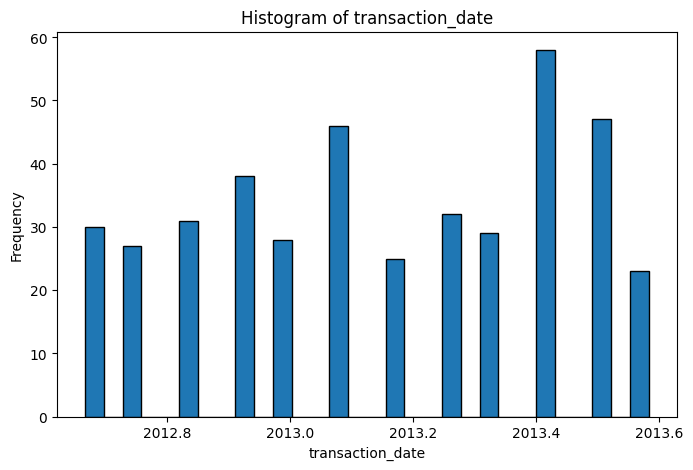

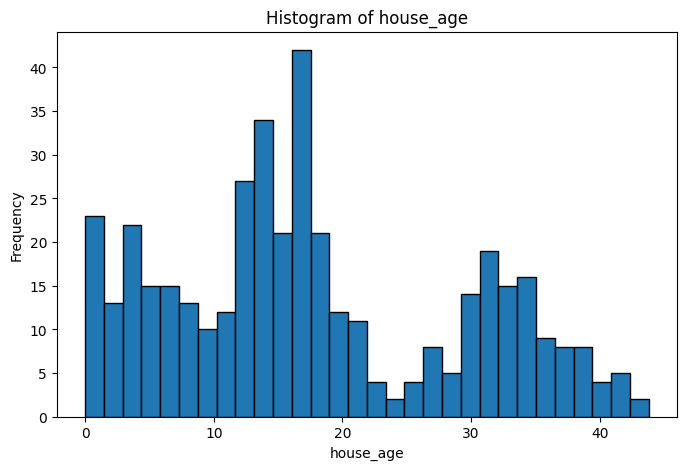

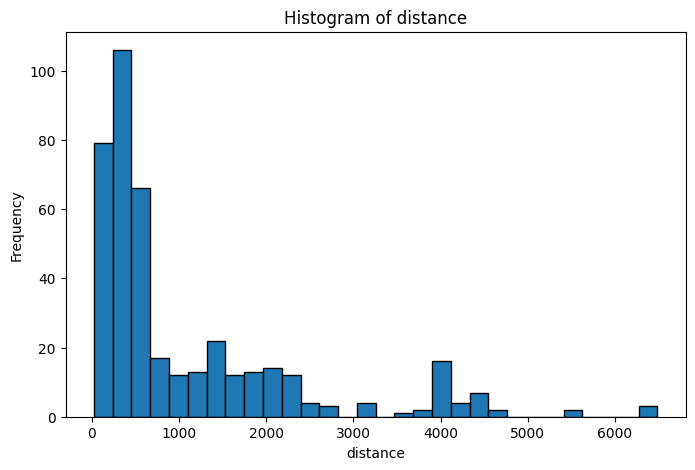

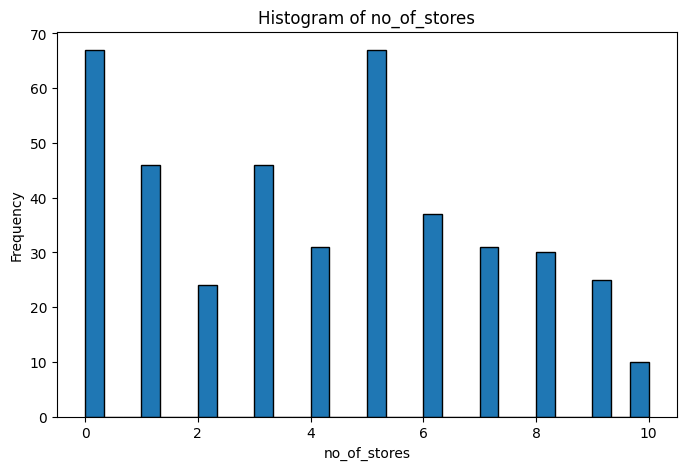

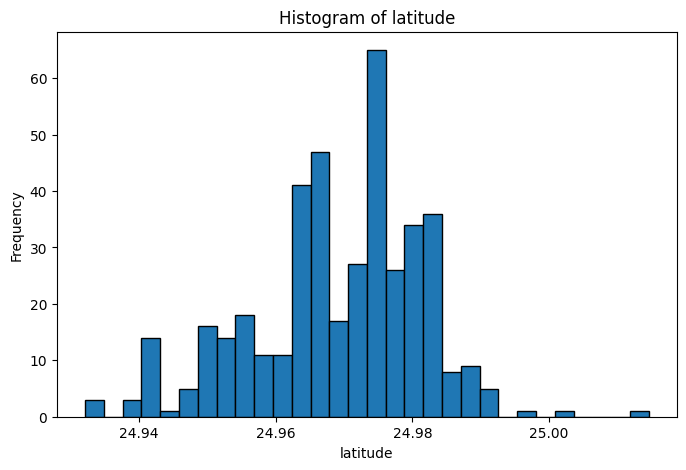

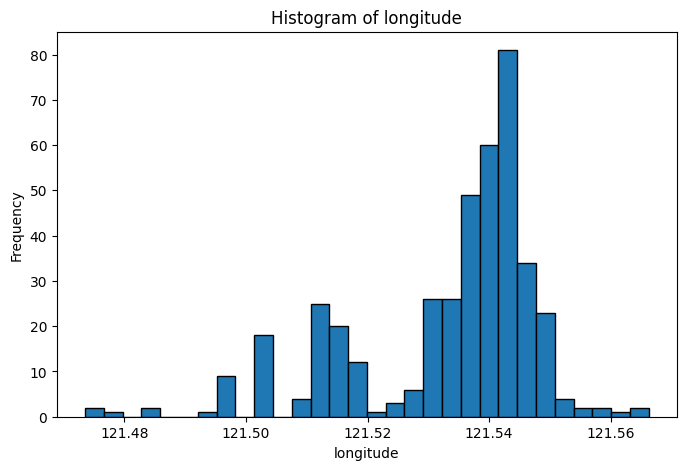

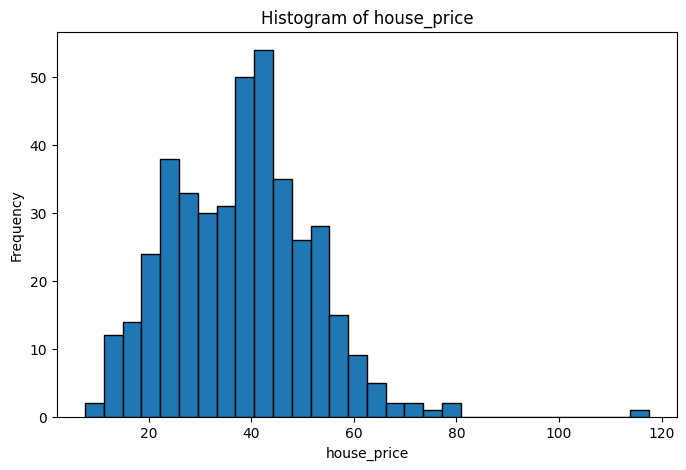

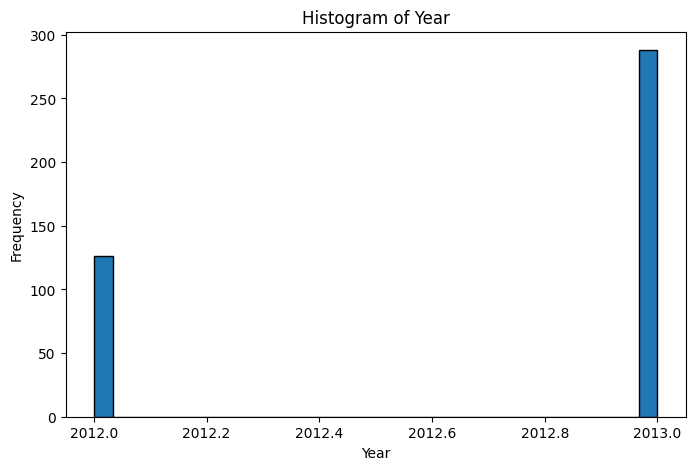

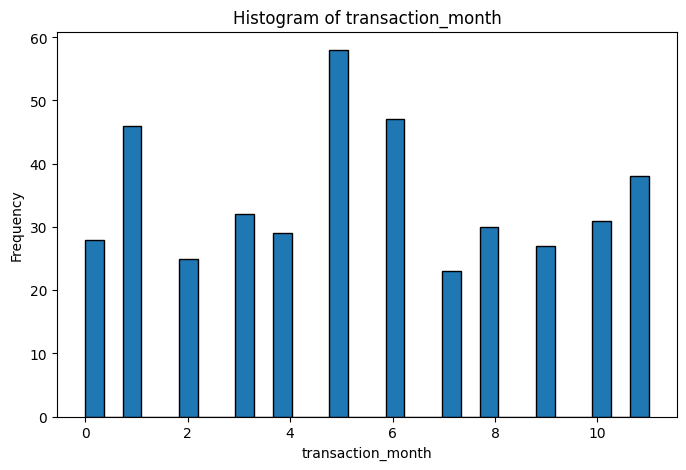

In [47]:
# YOUR CODE HERE
# Importing necessary libraries
import matplotlib.pyplot as plt

# for field in dataset.schema.fields:
#     print(str(field.dataType))
numeric_columns = [field.name for field in dataset.schema.fields if str(field.dataType) in ['IntegerType()', 'FloatType()', 'DoubleType()']]
print(numeric_columns)
for column in numeric_columns:
    data = dataset.select(column).rdd.flatMap(lambda x: x).collect()
    plt.figure(figsize=(8, 5))
    plt.hist(data, bins=30, edgecolor='black')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

#### Visualize the transaction date using the countplot

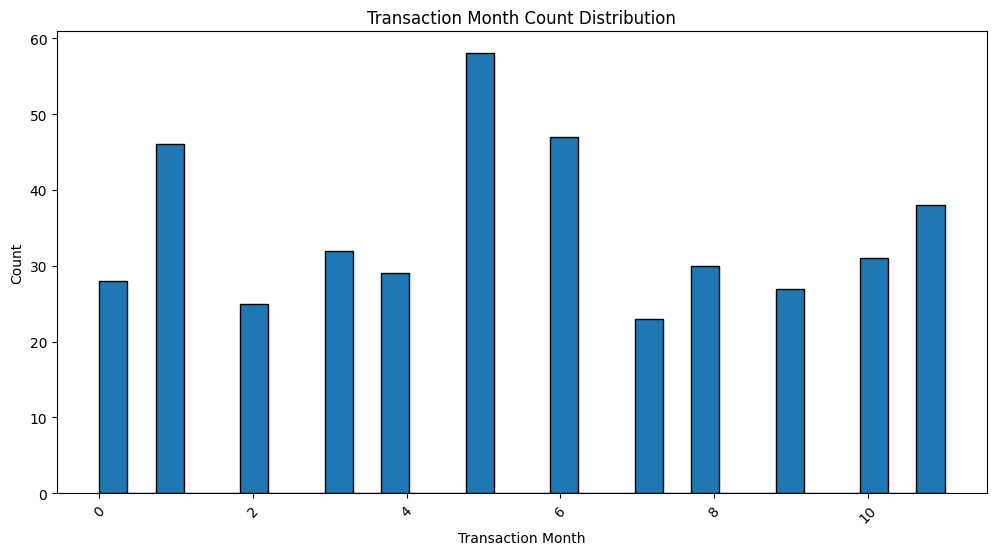

In [48]:
# YOUR CODE HERE
transaction_month = dataset.select("transaction_month").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(12, 6))
plt.hist(transaction_month, bins=30, edgecolor='black')
plt.title('Transaction Month Count Distribution')
plt.xlabel('Transaction Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

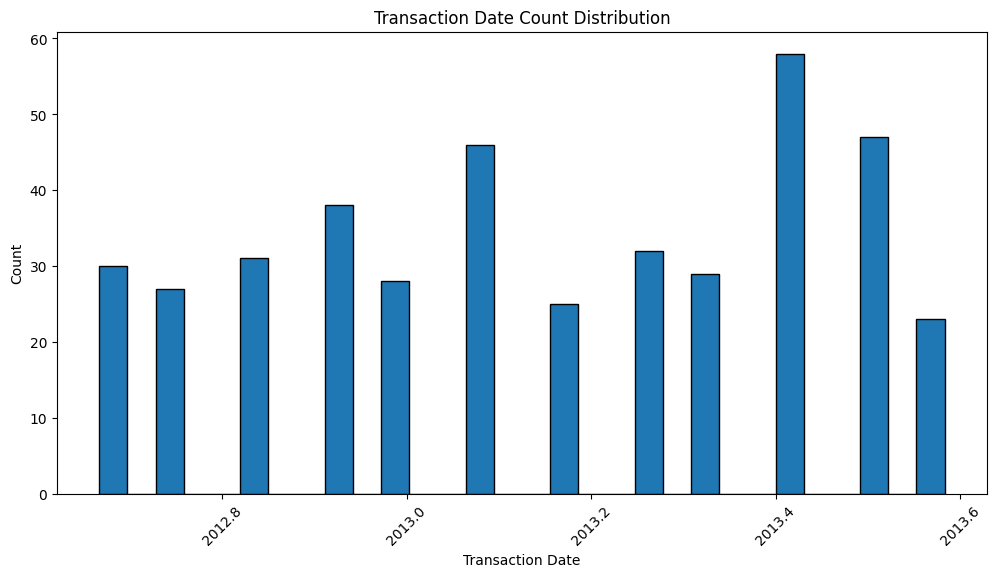

In [49]:
transaction_dates = dataset.select("transaction_date").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(12, 6))
plt.hist(transaction_dates, bins=30, edgecolor='black')
plt.title('Transaction Date Count Distribution')
plt.xlabel('Transaction Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

#### visualize number of convenience stores with appropriate plot.

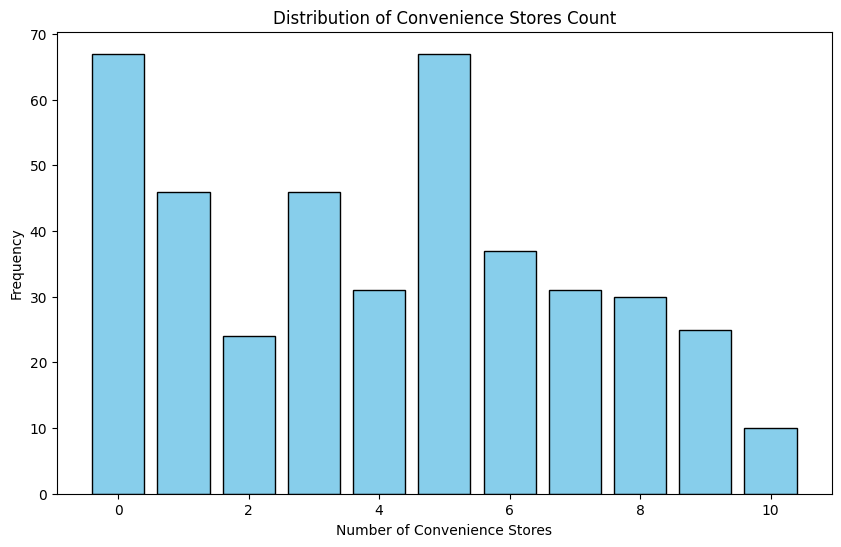

In [50]:
# YOUR CODE HERE
convenience_store_counts = dataset.groupBy("no_of_stores").count().orderBy("no_of_stores").collect()

# Extracting values for plotting
counts = [row['count'] for row in convenience_store_counts]
store_numbers = [row['no_of_stores'] for row in convenience_store_counts]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(store_numbers, counts, color='skyblue', edgecolor='black')
plt.title('Distribution of Convenience Stores Count')
plt.xlabel('Number of Convenience Stores')
plt.ylabel('Frequency')
plt.show()

#### visualize the geographical distribution of the house prices of unit area

With:

* x-axis = X6 longitude
* y-axis = X5 latitude
* datapoints = Y house price of unit area
* parameters including size `s` and color map `cmap`

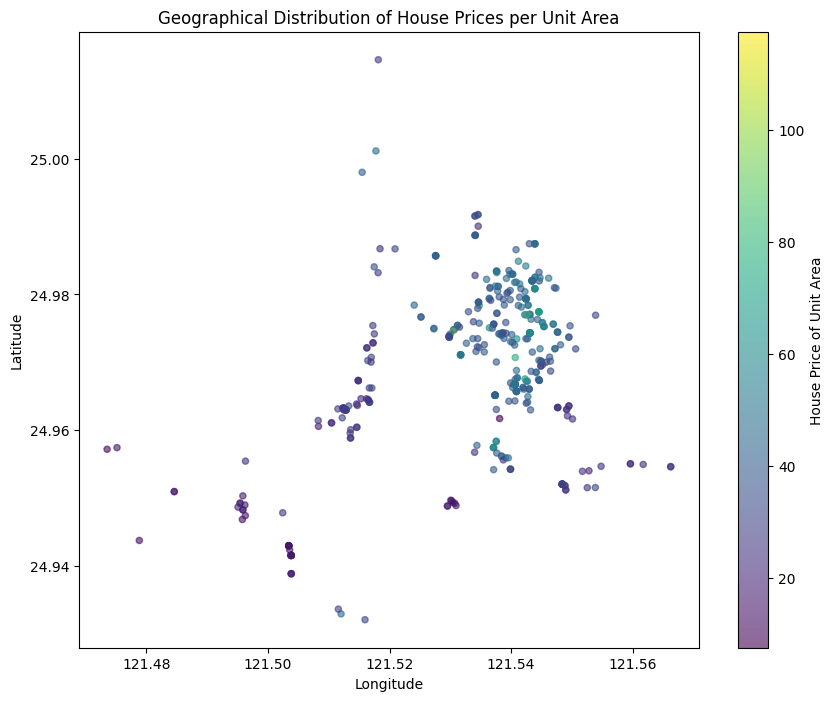

In [61]:
# YOUR CODE HERE
geo_data = dataset.select("longitude", "latitude", "house_price").toPandas()

# Plotting scatter plot for geographical distribution
plt.figure(figsize=(10, 8))
sc = plt.scatter(geo_data["longitude"], geo_data["latitude"], c=geo_data["house_price"], s=20, cmap='viridis', alpha=0.6)
plt.colorbar(sc, label='House Price of Unit Area')
plt.title('Geographical Distribution of House Prices per Unit Area')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Feature Scaling (1 point)

#### Identify the outliers

Use the pairplot or boxplot to identify the outliers

   **Hint:** `sns.pairplot`

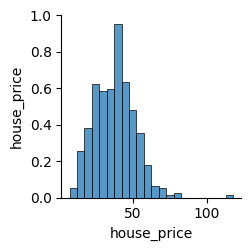

In [63]:
# YOUR CODE HERE
sns.pairplot(dataset.select("house_price").toPandas())

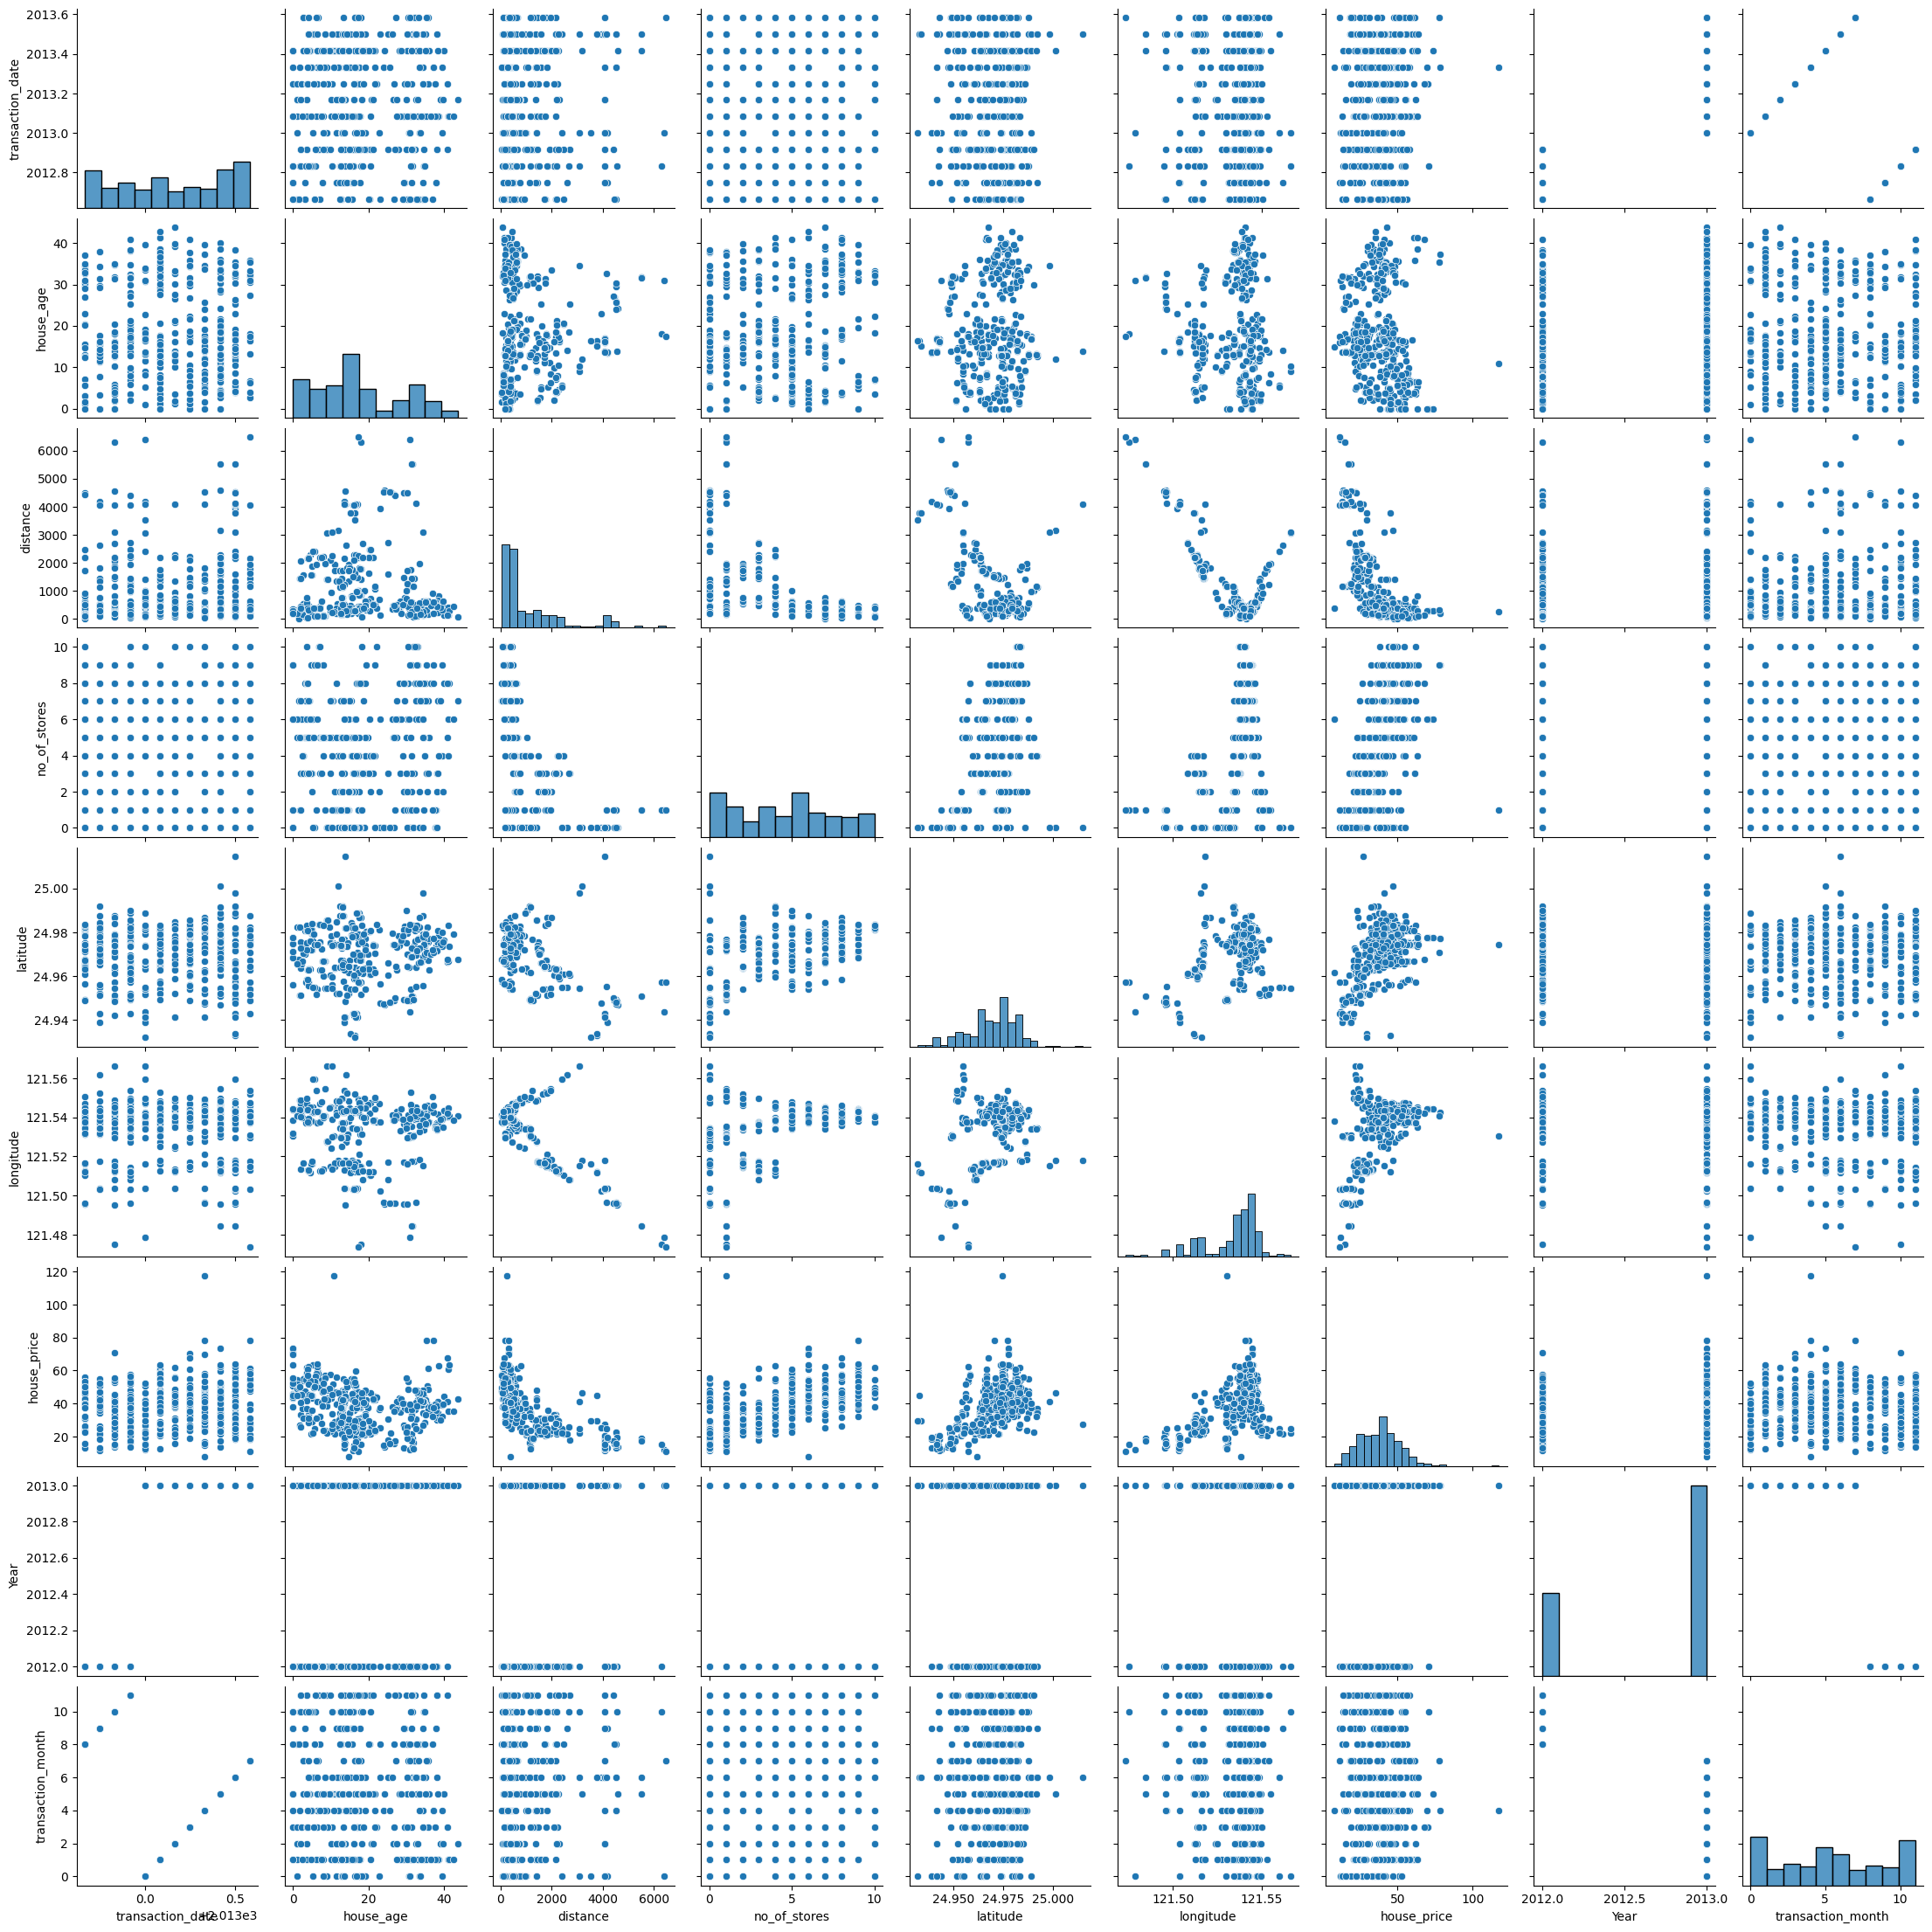

In [64]:
sns.pairplot(dataset.toPandas())

#### Correlation analysis

create the correlation matrix of all the columns and visualize using the heatmap

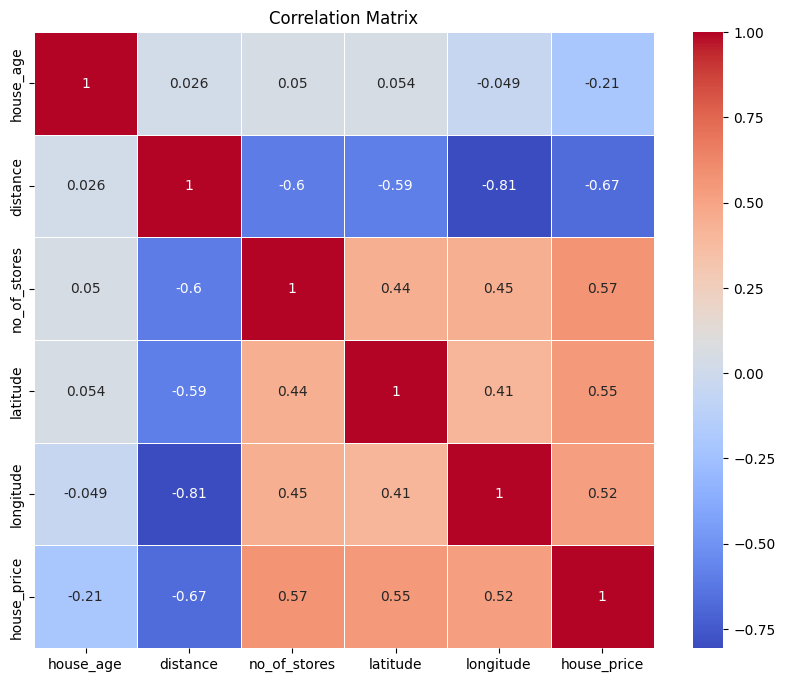

In [65]:
# YOUR CODE HERE
corr_matrix = dataset.select("house_age", "distance", "no_of_stores", "latitude", "longitude", "house_price").toPandas().corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

#### Normalization or standardization

select the applicable features using vector assembler and apply scaling using `MinMaxScaler` from pyspark

Hint: [MinMaxScaler](https://spark.apache.org/docs/latest/ml-features#minmaxscaler)

In [66]:
# YOUR CODE HERE
assembler = VectorAssembler(inputCols=["house_age", "distance", "no_of_stores", "latitude", "longitude"], outputCol="features")
dataset = assembler.transform(dataset)
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(dataset)
dataset = scaler_model.transform(dataset)
dataset.show(5)

+----------------+---------+--------+------------+--------+---------+-----------+----+-----------------+--------------------+--------------------+
|transaction_date|house_age|distance|no_of_stores|latitude|longitude|house_price|Year|transaction_month|            features|     scaled_features|
+----------------+---------+--------+------------+--------+---------+-----------+----+-----------------+--------------------+--------------------+
|        2012.917|     32.0|84.87882|          10|24.98298|121.54024|       37.9|2012|               11|[32.0,84.87882,10...|[0.73059360730593...|
|        2012.917|     19.5|306.5947|           9|24.98034|121.53951|       42.2|2012|               11|[19.5,306.5947,9....|[0.44520547945205...|
|        2013.583|     13.3|561.9845|           5|24.98746|121.54391|       47.3|2013|                7|[13.3,561.9845,5....|[0.30365296803652...|
|          2013.5|     13.3|561.9845|           5|24.98746|121.54391|       54.8|2013|                6|[13.3,561.9845

### Feature Engineering (2 points)

#### Assemble the features

concatenate all the features into a single vector which can be further passed to the ML algorithm.

**Hint:** `VectorAssembler()`

In [68]:
# YOUR CODE HERE


#### Feature selection and splitting the data

In [56]:
# YOUR CODE HERE

### Train and Evaluate the model (2 points)

Using LinearRegression from `pyspark.ml` fit the data and find the coefficients and intercept

In [57]:
regressor = LinearRegression(featuresCol='features', labelCol='label')

In [58]:
# YOUR CODE HERE

Get the predictions and show the table along with actual data and predicted data

In [59]:
# YOUR CODE HERE

Calculate the RMSE and $R^2$ of the model

In [60]:
# YOUR CODE HERE